<a href="https://colab.research.google.com/github/JayPBhatia/CPSProject/blob/main/LIT301.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
import math
import os
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from statsmodels.tsa.stattools import acf, pacf, grangercausalitytests, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX


import scipy.stats as scs

from tqdm import tqdm_notebook


import warnings
warnings.filterwarnings('ignore')


%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 7.5]

seed = 7
np.random.seed(seed)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Dataset

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/JayPBhatia/CPSProject/main/LIT301data.csv")
#df = pd.read_csv("https://raw.githubusercontent.com/JayPBhatia/CPSProject/main/LIT301_7k.csv")
#df = pd.read_csv("https://raw.githubusercontent.com/JayPBhatia/CPSProject/main/LIT301_100xRun_data.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5729 entries, 0 to 5728
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FIT201  5729 non-null   float64
 1   LIT301  5729 non-null   float64
 2   FIT301  5729 non-null   float64
dtypes: float64(3)
memory usage: 134.4 KB


In [4]:
df.describe()

,FIT201,LIT301,FIT301
count,5729.000000,5729.000000,5729.000000
mean,2.143044,884.332551,1.954453
std,0.832377,57.385565,0.720834
min,0.000000,796.130719,0.000000
25%,2.471022,840.087625,2.229382
50%,2.471022,872.762072,2.229382
75%,2.471022,937.973703,2.229382
max,2.471022,1005.489426,2.326234


In [5]:
def adfuller_test(series, signif=0.05):
  x = adfuller(series, autolag='AIC')
  output = {' P-value': x[1], 
              f'isStationary (P Value <  {signif})': x[1] < signif }
            
  return pd.Series(output)
df.dropna().apply(lambda x: adfuller_test(x), axis=0)

,FIT201,LIT301,FIT301
P-value,0.000274,0.530379,0.0
isStationary (P Value < 0.05),True,False,True


## Features 

In [6]:
df['FIT_Diff'] = df['FIT201'] - df['FIT301']
df['LIT_Diff'] = df['LIT301'].diff()
df = df[['FIT201','FIT301','LIT301','FIT_Diff','LIT_Diff']]
#df = df[['FIT201','FIT301','LIT301']]
df = df.dropna()

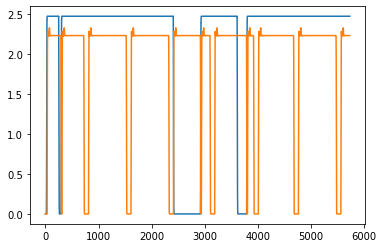

In [7]:
plt.plot(df['FIT201'])
plt.plot(df['FIT301'])

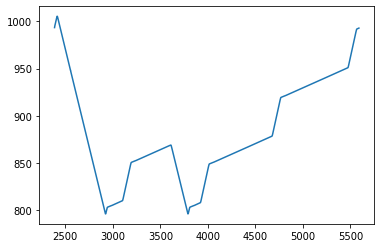

In [8]:
plt.plot(df['LIT301'][2385:5590])

In [9]:
#df_new = df.iloc[ 2385:5590, :].reset_index(drop=True)
#df_new = pd.concat([df_new]*10,ignore_index=True)
#df = df_new

In [10]:
def adfuller_test(series, signif=0.05):
  x = adfuller(series, autolag='AIC')
  output = {' P-value': x[1], 
              f'isStationary (P Value <  {signif})': x[1] < signif }
            
  return pd.Series(output)
df.dropna().apply(lambda x: adfuller_test(x), axis=0)

,FIT201,FIT301,LIT301,FIT_Diff,LIT_Diff
P-value,0.000271,0.0,0.615091,0.000009,0.000007
isStationary (P Value < 0.05),True,True,False,True,True


In [11]:
df

,FIT201,FIT301,LIT301,FIT_Diff,LIT_Diff
1,0.000000,0.000000,798.000000,0.00000,0.000000
2,0.000000,0.000000,798.000000,0.00000,0.000000
3,0.000000,0.000000,798.000000,0.00000,0.000000
4,0.000000,0.000000,798.000000,0.00000,0.000000
5,0.000000,0.000000,798.000000,0.00000,0.000000
...,...,...,...,...,...
5724,2.471022,2.229382,998.759508,0.24164,0.044876
5725,2.471022,2.229382,998.804384,0.24164,0.044876
5726,2.471022,2.229382,998.849261,0.24164,0.044876
5727,2.471022,2.229382,998.894137,0.24164,0.044876


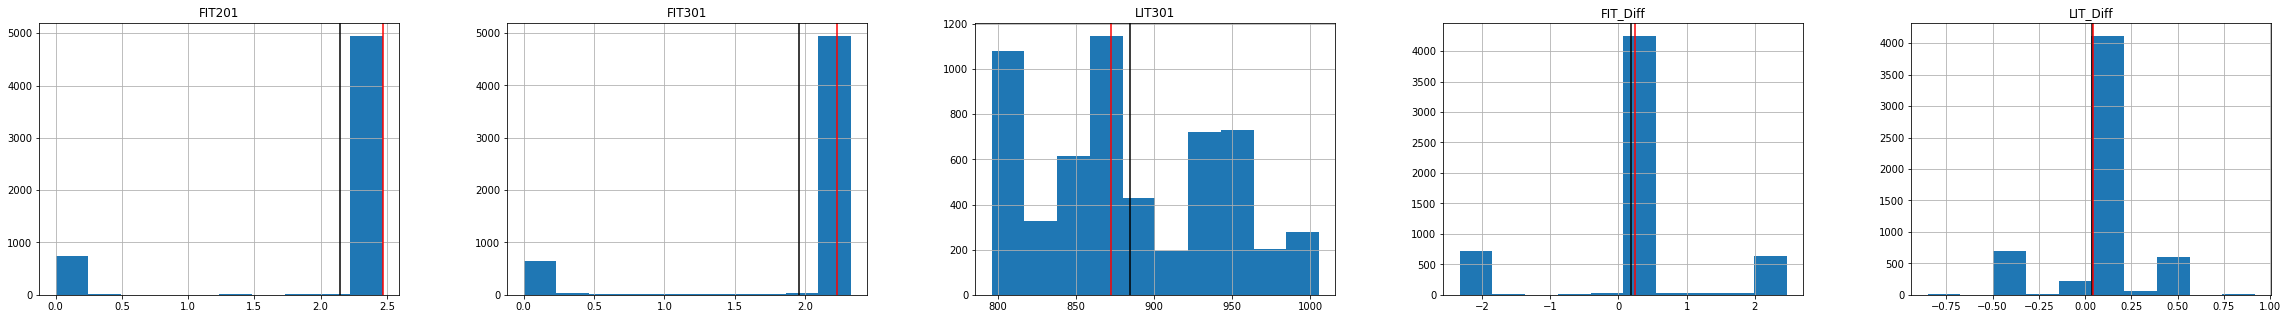

In [12]:
axes = df.hist(layout=(1,len(df.columns)), figsize=(40,5))
for ax, col in zip(axes[0], df.columns):  # For each column...
    ax.axvline(df[col].mean(), c='k')  # Plot mean
    ax.axvline(df[col].median(), c='r')  # Plot median 
plt.show()

## Normalization

In [13]:
n = len(df)
train_df = df[0:int(n*0.8)].copy()
val_df = df[int(n*0.8):int(n*0.9)].copy()
test_df = df[int(n*0.9):].copy()

In [14]:
train_df

,FIT201,FIT301,LIT301,FIT_Diff,LIT_Diff
1,0.000000,0.000000,798.000000,0.00000,0.000000
2,0.000000,0.000000,798.000000,0.00000,0.000000
3,0.000000,0.000000,798.000000,0.00000,0.000000
4,0.000000,0.000000,798.000000,0.00000,0.000000
5,0.000000,0.000000,798.000000,0.00000,0.000000
...,...,...,...,...,...
4578,2.471022,2.229382,874.082286,0.24164,0.044876
4579,2.471022,2.229382,874.127162,0.24164,0.044876
4580,2.471022,2.229382,874.172038,0.24164,0.044876
4581,2.471022,2.229382,874.216915,0.24164,0.044876


In [15]:
val_df

,FIT201,FIT301,LIT301,FIT_Diff,LIT_Diff
4583,2.471022,2.229382,874.306668,0.24164,0.044876
4584,2.471022,2.229382,874.351544,0.24164,0.044876
4585,2.471022,2.229382,874.396421,0.24164,0.044876
4586,2.471022,2.229382,874.441297,0.24164,0.044876
4587,2.471022,2.229382,874.486173,0.24164,0.044876
...,...,...,...,...,...
5151,2.471022,2.229382,936.420445,0.24164,0.044876
5152,2.471022,2.229382,936.465321,0.24164,0.044876
5153,2.471022,2.229382,936.510197,0.24164,0.044876
5154,2.471022,2.229382,936.555074,0.24164,0.044876


In [16]:
test_df

,FIT201,FIT301,LIT301,FIT_Diff,LIT_Diff
5156,2.471022,2.229382,936.644827,0.24164,0.044876
5157,2.471022,2.229382,936.689703,0.24164,0.044876
5158,2.471022,2.229382,936.734580,0.24164,0.044876
5159,2.471022,2.229382,936.779456,0.24164,0.044876
5160,2.471022,2.229382,936.824332,0.24164,0.044876
...,...,...,...,...,...
5724,2.471022,2.229382,998.759508,0.24164,0.044876
5725,2.471022,2.229382,998.804384,0.24164,0.044876
5726,2.471022,2.229382,998.849261,0.24164,0.044876
5727,2.471022,2.229382,998.894137,0.24164,0.044876


In [17]:
from sklearn import preprocessing
x_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()
cols = train_df.columns 
x_scaler.fit(train_df[cols[ :-1]])
y_scaler.fit(train_df[cols[-1]].values.reshape(-1, 1) )

MinMaxScaler()

In [18]:
import joblib
x_scaler_filename = "x_scaler.save"
joblib.dump(x_scaler, x_scaler_filename) 

y_scaler_filename = "y_scaler.save"
joblib.dump(y_scaler, y_scaler_filename) 

['y_scaler.save']

In [19]:
train_df[cols[ :-1]]

,FIT201,FIT301,LIT301,FIT_Diff
1,0.000000,0.000000,798.000000,0.00000
2,0.000000,0.000000,798.000000,0.00000
3,0.000000,0.000000,798.000000,0.00000
4,0.000000,0.000000,798.000000,0.00000
5,0.000000,0.000000,798.000000,0.00000
...,...,...,...,...
4578,2.471022,2.229382,874.082286,0.24164
4579,2.471022,2.229382,874.127162,0.24164
4580,2.471022,2.229382,874.172038,0.24164
4581,2.471022,2.229382,874.216915,0.24164


In [20]:
train_df_scaled = train_df.copy()
train_df_scaled[cols[ :-1]] = pd.DataFrame(x_scaler.transform(train_df[cols[ :-1]]))
train_df_scaled[cols[-1]] = pd.DataFrame(y_scaler.transform(train_df[cols[-1]].values.reshape(-1, 1)))
train_df_scaled = train_df_scaled.dropna()
train_df_scaled

,FIT201,FIT301,LIT301,FIT_Diff,LIT_Diff
1,0.0,0.000000,0.008929,0.484909,0.481071
2,0.0,0.000000,0.008929,0.484909,0.481071
3,0.0,0.000000,0.008929,0.484909,0.481071
4,0.0,0.000000,0.008929,0.484909,0.481071
5,0.0,0.000000,0.008929,0.484909,0.481071
...,...,...,...,...,...
4577,1.0,0.958365,0.372335,0.535280,0.506444
4578,1.0,0.958365,0.372549,0.535280,0.506444
4579,1.0,0.958365,0.372764,0.535280,0.506444
4580,1.0,0.958365,0.372978,0.535280,0.506444


In [21]:
val_df_scaled = train_df.copy()
val_df_scaled[cols[ :-1]] = pd.DataFrame(x_scaler.transform(val_df[cols[ :-1]]))
val_df_scaled[cols[-1]] = pd.DataFrame(y_scaler.transform(val_df[cols[-1]].values.reshape(-1, 1)))
val_df_scaled = val_df_scaled.dropna()
val_df_scaled

,FIT201,FIT301,LIT301,FIT_Diff,LIT_Diff
1,1.0,0.958365,0.373621,0.53528,0.506444
2,1.0,0.958365,0.373835,0.53528,0.506444
3,1.0,0.958365,0.374050,0.53528,0.506444
4,1.0,0.958365,0.374264,0.53528,0.506444
5,1.0,0.958365,0.374478,0.53528,0.506444
...,...,...,...,...,...
568,1.0,0.958365,0.670093,0.53528,0.506444
569,1.0,0.958365,0.670307,0.53528,0.506444
570,1.0,0.958365,0.670521,0.53528,0.506444
571,1.0,0.958365,0.670736,0.53528,0.506444


In [22]:
test_df_scaled = train_df.copy()
test_df_scaled[ cols[ :-1] ] = pd.DataFrame(x_scaler.transform(test_df[cols[ :-1]]))
test_df_scaled[ cols[-1] ] = pd.DataFrame(y_scaler.transform(test_df[cols[-1]].values.reshape(-1, 1)))
test_df_scaled = test_df_scaled.dropna()
test_df_scaled

,FIT201,FIT301,LIT301,FIT_Diff,LIT_Diff
1,1.0,0.958365,0.671379,0.53528,0.506444
2,1.0,0.958365,0.671593,0.53528,0.506444
3,1.0,0.958365,0.671807,0.53528,0.506444
4,1.0,0.958365,0.672022,0.53528,0.506444
5,1.0,0.958365,0.672236,0.53528,0.506444
...,...,...,...,...,...
568,1.0,0.958365,0.967855,0.53528,0.506444
569,1.0,0.958365,0.968069,0.53528,0.506444
570,1.0,0.958365,0.968283,0.53528,0.506444
571,1.0,0.958365,0.968498,0.53528,0.506444


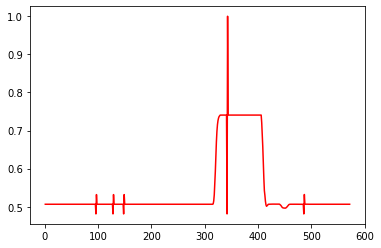

In [23]:
plt.plot(test_df_scaled.iloc[ :,-1], color='red')

## Multivariate Bidirectional LSTM Model

In [24]:
from numpy import array
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [25]:
n_steps = 32
X_train, y_train = split_sequences(train_df_scaled.values, n_steps)
X_val, y_val = split_sequences(val_df_scaled.values, n_steps)
X_test, y_test = split_sequences(test_df_scaled.values, n_steps)


In [26]:
import tensorflow as tf
from numpy import array



# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(128)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(32)
                                
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Bidirectional( tf.keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]))))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer=tf.optimizers.Adam(), loss=tf.losses.MeanSquaredError(), metrics=["mse",  "mae"])
history = model.fit(train_dataset, validation_data=val_dataset, epochs=32, validation_steps=8)

Epoch 1/32
36/36 [==============================] - 6s 38ms/step - loss: 0.0335 - mse: 0.0335 - mae: 0.1292 - val_loss: 0.0028 - val_mse: 0.0028 - val_mae: 0.0381
Epoch 2/32
36/36 [==============================] - 0s 9ms/step - loss: 0.0025 - mse: 0.0025 - mae: 0.0351 - val_loss: 0.0013 - val_mse: 0.0013 - val_mae: 0.0254
Epoch 3/32
36/36 [==============================] - 0s 10ms/step - loss: 7.9724e-04 - mse: 7.9724e-04 - mae: 0.0120 - val_loss: 7.2626e-04 - val_mse: 7.2626e-04 - val_mae: 0.0107
Epoch 4/32
36/36 [==============================] - 0s 9ms/step - loss: 6.7294e-04 - mse: 6.7294e-04 - mae: 0.0088 - val_loss: 6.7219e-04 - val_mse: 6.7219e-04 - val_mae: 0.0093
Epoch 5/32
36/36 [==============================] - 0s 10ms/step - loss: 6.2189e-04 - mse: 6.2189e-04 - mae: 0.0079 - val_loss: 6.7553e-04 - val_mse: 6.7553e-04 - val_mae: 0.0105
Epoch 6/32
36/36 [==============================] - 0s 10ms/step - loss: 5.9271e-04 - mse: 5.9271e-04 - mae: 0.0075 - val_loss: 6.0371e-04 

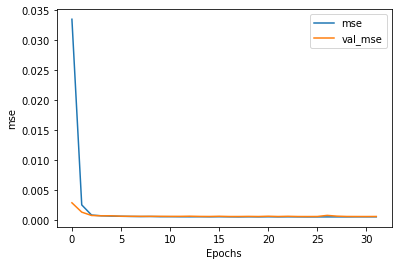

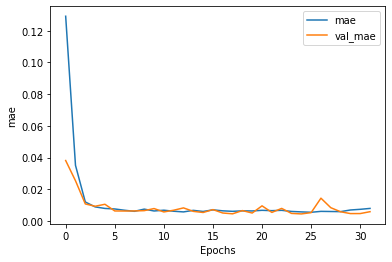

In [27]:
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'mse')
plot_history(history, 'mae')

In [28]:
y_pred=model.predict(X_test)

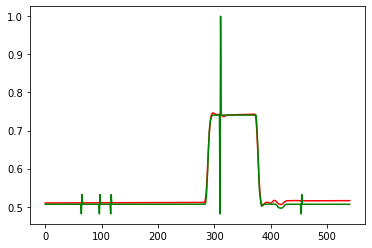

In [29]:
plt.plot(y_pred, color='red')
plt.plot(y_test, color='green')

[0.46214831]


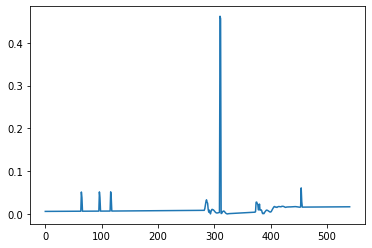

In [30]:
y_test_inv = y_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = y_scaler.inverse_transform(y_pred.reshape(-1, 1))

print(max(abs(y_pred_inv-y_test_inv)))
plt.plot(abs(y_pred_inv-y_test_inv))

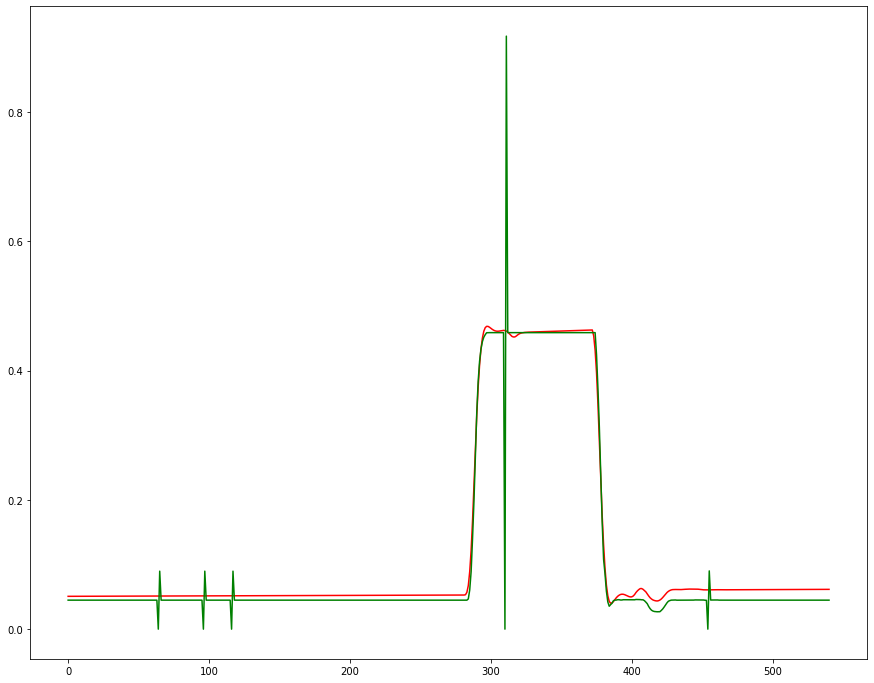

In [31]:
plt.figure(figsize=(15,12))
plt.plot(y_pred_inv, color='red')
plt.plot(y_test_inv, color='green')

In [32]:
model.save('lit301.h5')

In [48]:
#df_eval = pd.read_csv("https://raw.githubusercontent.com/JayPBhatia/CPSProject/main/LIT301_7k.csv")
df_eval = pd.read_csv("https://raw.githubusercontent.com/JayPBhatia/CPSProject/main/LIT301_100xRun_data.csv")

In [49]:
df_eval['FIT_Diff'] = df_eval['FIT201'] - df_eval['FIT301']
df_eval['LIT_Diff'] = df_eval['LIT301'].diff()
df_eval = df_eval[['FIT201','FIT301','LIT301','FIT_Diff','LIT_Diff']]
df_eval = df_eval.dropna()
df_eval

,FIT201,FIT301,LIT301,FIT_Diff,LIT_Diff
1,2.471022,0.0,798.458908,2.471022,-1.026970
2,0.000000,0.0,798.917817,0.000000,0.458908
3,0.000000,0.0,798.917817,0.000000,0.000000
4,2.465383,0.0,798.917817,2.465383,0.000000
5,2.465383,0.0,799.375678,2.465383,0.457861
...,...,...,...,...,...
13662,2.471022,0.0,838.842779,2.471022,0.458908
13663,2.471022,0.0,839.760596,2.471022,0.917817
13664,2.471022,0.0,840.219505,2.471022,0.458908
13665,2.471022,0.0,840.678413,2.471022,0.458908


In [50]:
new_x_scaler = joblib.load('x_scaler.save')
new_y_scaler = joblib.load('y_scaler.save')

df_eval_scaled = df_eval.copy()
df_eval_scaled[cols[ :-1]] = pd.DataFrame(new_x_scaler.transform(df_eval[cols[ :-1]]))
df_eval_scaled[cols[-1]] = pd.DataFrame(new_y_scaler.transform(df_eval[cols[-1]].values.reshape(-1, 1)))
df_eval_scaled = df_eval_scaled.dropna()
df_eval_scaled

,FIT201,FIT301,LIT301,FIT_Diff,LIT_Diff
1,0.000000,0.0,0.013313,0.484909,0.740535
2,0.000000,0.0,0.013313,0.484909,0.481071
3,0.997718,0.0,0.013313,0.998825,0.481071
4,0.997718,0.0,0.015500,0.998825,0.739943
5,0.998807,0.0,0.015500,0.999385,0.481071
...,...,...,...,...,...
13661,1.000000,0.0,0.204014,1.000000,0.740535
13662,1.000000,0.0,0.208398,1.000000,1.000000
13663,1.000000,0.0,0.210590,1.000000,0.740535
13664,1.000000,0.0,0.212782,1.000000,0.740535


In [51]:
df_eval_scaled[cols[ :-1]]

,FIT201,FIT301,LIT301,FIT_Diff
1,0.000000,0.0,0.013313,0.484909
2,0.000000,0.0,0.013313,0.484909
3,0.997718,0.0,0.013313,0.998825
4,0.997718,0.0,0.015500,0.998825
5,0.998807,0.0,0.015500,0.999385
...,...,...,...,...
13661,1.000000,0.0,0.204014,1.000000
13662,1.000000,0.0,0.208398,1.000000
13663,1.000000,0.0,0.210590,1.000000
13664,1.000000,0.0,0.212782,1.000000


In [52]:
new_model = tf.keras.models.load_model('lit301.h5')
X_eval, y_eval = split_sequences(df_eval_scaled.values, n_steps)
loss, mse,mae = new_model.evaluate(X_eval, y_eval, verbose=0)
print(loss, mse,mae )

0.0078273955732584 0.0078273955732584 0.0416758693754673


In [53]:
y_eval_pred = new_model.predict(X_eval)

In [54]:
y_eval_inv = new_y_scaler.inverse_transform(y_eval.reshape(-1, 1))
y_eval_pred_inv = new_y_scaler.inverse_transform(y_eval_pred.reshape(-1, 1))


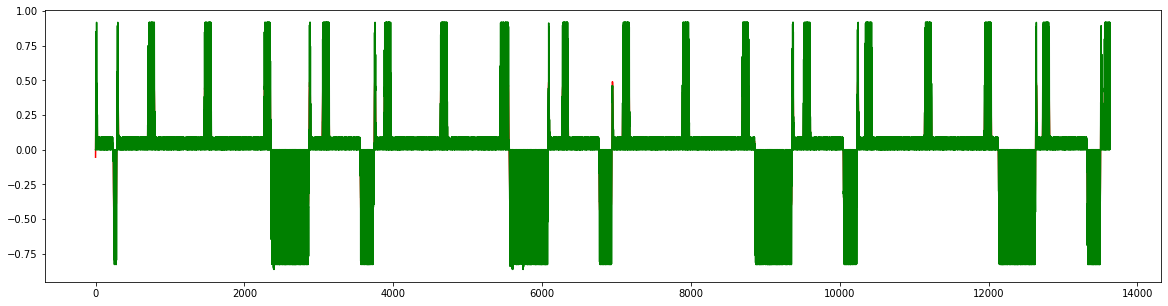

In [58]:
plt.figure(figsize=(20,5))
plt.plot(y_eval_pred_inv, color='red')
plt.plot(y_eval_inv, color='green')

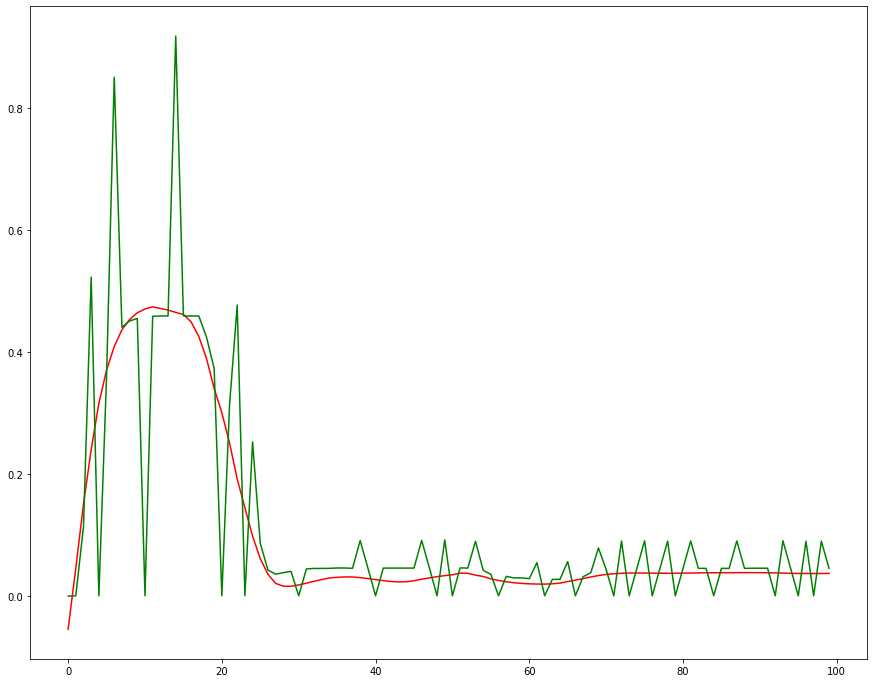

In [55]:
plt.figure(figsize=(15,12))
plt.plot(y_eval_pred_inv[:100], color='red')
plt.plot(y_eval_inv[:100], color='green')